# ZFNet

Source: https://towardsdatascience.com/zfnet-an-explanation-of-paper-with-code-f1bd6752121d

In [1]:
model_name = 'ZFNet-pre-processing-hist-eq-dark-and-canny-non-empty-1'

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import imageio as iio
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from PIL import Image
from numba import cuda  # https://stackoverflow.com/a/52354865/6476994
import keras
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import csv
import re
from datetime import datetime
import collections
from readInImages import readInImages
from readInAnnotations import readInAnnotations

In [3]:
# allows all images to be displayed at once (else only displays the last call to plt.imshow())
# https://stackoverflow.com/a/41210974
def displayImage(image, caption = None, colour = None) -> None:
    plt.figure()
    if(colour != None):
        plt.imshow(image, cmap=colour)
    else:
        plt.imshow(image)
        
    if(caption != None):
        # display caption below picture (https://stackoverflow.com/a/51486361)
        plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)

In [4]:
# free up GPU if it didn't after the last run
cuda.select_device(0)
cuda.close()

## Read in dataset

* first argument is the `using_batch_generator` flag
* second argument is `do_preprocessing`, which will perform image manipulations for the purposes of enhancing training performance
* all other arguments are the datasets - e.g., a folder ('20160724_July') with additional folders ('BB01', 'BB02', ..., 'BBXY'), each containing a set of images)

In [5]:
%run readInDataset.py true true 20160724_July 20160829_August

args: ['readInDataset.py', 'true', 'true', '20160724_July', '20160829_August']
using_batch_generator? True
doing pre-processing? True
dataset_names: ['20160724_July', '20160829_August']
reading in images and labels for dataset: 20160724_July
all_folders_for_curr_dataset: ['BB01', 'BB02', 'BB03', 'BB04', 'BB05', 'BB06', 'BB07', 'BB08', 'BB09', 'BB10', 'BB11', 'BB12', 'BB13', 'BB14', 'BB15', 'BB16', 'BB17', 'BB18', 'BB19', 'BB20', 'BB21', 'BB22', 'BB23', 'BB24', 'BB25', 'BB26', 'BB27', 'BB28', 'BB29', 'BB30', 'BB31', 'BB32', 'BB33', 'BB34', 'BB35', 'BB36']
reading in labels for subset: BB01
returning labelList of length: 285
reading in images for subset: BB01
all_image_filenames length: 285
done current subset
reading in labels for subset: BB02
returning labelList of length: 45
reading in images for subset: BB02
all_image_filenames length: 45
done current subset
reading in labels for subset: BB03
returning labelList of length: 230
reading in images for subset: BB03
all_image_filenames le

In [6]:
class CustomGenerator(keras.utils.Sequence):    
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
    
    def __len__(self):
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)

    def __getitem__(self, idx):
        batch_x = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        
        return batch_x, np.array(batch_y)

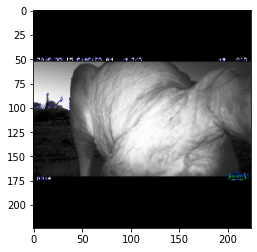

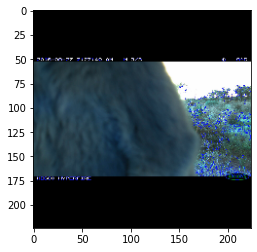

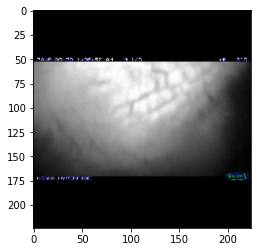

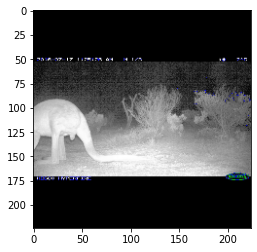

In [7]:
batch_size = 128

num_len_train = int(0.8 * len(training_images))

ttraining_images = training_images[:num_len_train]
ttraining_labels = training_labels[:num_len_train]

valid_images = training_images[num_len_train:]
valid_labels = training_labels[num_len_train:]

training_images = ttraining_images
training_labels = ttraining_labels

# show a few samples
displayImage(training_images[0])
displayImage(training_images[10])
displayImage(training_images[100])
displayImage(training_images[1000])

training_batch_generator = CustomGenerator(training_images, training_labels, batch_size)
validation_batch_generator = CustomGenerator(valid_images, valid_labels, batch_size)

## Train the model

In [8]:
model = tf.keras.models.Sequential([                                    
    tf.keras.layers.Conv2D(96, (7, 7), strides=(2, 2), activation='relu',input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Lambda(lambda x: tf.image.per_image_standardization(x)),
    tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Lambda(lambda x: tf.image.per_image_standardization(x)),
    tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9), \
              loss='categorical_crossentropy', \
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(5)])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', \
    factor=0.1, patience=1, \
    min_lr=0.00001)

model.fit(training_batch_generator,
          validation_data=validation_batch_generator,
          epochs=90,
          callbacks=[reduce_lr])

Epoch 1/90


2022-06-07 06:02:36.053010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 06:02:36.069270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 06:02:36.069493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 06:02:36.070111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

89/89 [==============================] - 19s 178ms/step - loss: 1.3772 - accuracy: 0.6147 - top_k_categorical_accuracy: 0.9584 - val_loss: 0.9910 - val_accuracy: 0.6703 - val_top_k_categorical_accuracy: 0.9888 - lr: 0.0100
Epoch 2/90
89/89 [==============================] - 14s 159ms/step - loss: 0.9865 - accuracy: 0.6611 - top_k_categorical_accuracy: 0.9903 - val_loss: 0.9601 - val_accuracy: 0.6703 - val_top_k_categorical_accuracy: 0.9898 - lr: 0.0100
Epoch 3/90
89/89 [==============================] - 15s 164ms/step - loss: 0.9558 - accuracy: 0.6598 - top_k_categorical_accuracy: 0.9917 - val_loss: 0.8957 - val_accuracy: 0.6738 - val_top_k_categorical_accuracy: 0.9902 - lr: 0.0100
Epoch 4/90
89/89 [==============================] - 15s 169ms/step - loss: 0.8802 - accuracy: 0.6877 - top_k_categorical_accuracy: 0.9916 - val_loss: 0.8578 - val_accuracy: 0.6798 - val_top_k_categorical_accuracy: 0.9909 - lr: 0.0100
Epoch 5/90
89/89 [==============================] - 14s 161ms/step - loss: 

## Use test set to assess trained model's performance

### Evaluate

In [9]:
print('test_images shape: {}'.format(test_images.shape))
print('test_labels shape: {}'.format(test_labels.shape))

results = model.evaluate(test_images,test_labels)
print('loss: {}'.format(results[0]))
print('accuracy: {}'.format(results[1]))
print('top_k_categorical_accuracy: {}'.format(results[2]))

test_images shape: (3556, 224, 224, 3)
test_labels shape: (3556, 10)
112/112 [==============================] - 2s 16ms/step - loss: 0.1419 - accuracy: 0.9592 - top_k_categorical_accuracy: 0.9997
loss: 0.14185675978660583
accuracy: 0.9592238664627075
top_k_categorical_accuracy: 0.9997187852859497


### Predict and print classification report

In [10]:
predictions = (model.predict(test_images) > 0.5).astype("int32")

112/112 [==============================] - 2s 13ms/step


In [11]:
print("test_classes: {}".format(test_classes))
print("train classes count: {}".format(counter_test))
# classification_report uses alphabetic ordering of the classes, so to match the encoded labels to the target_names, provide a sortest list of classes
# https://stackoverflow.com/a/48495303
sorted_test_classes = sorted(test_classes)
print(classification_report(test_labels, predictions, target_names=sorted_test_classes))

test_classes: ['Kangaroo', 'Empty photo', 'Fox', 'Emu', 'Rabbit', 'Human Presense/Deployment', 'Cat', 'Dog', 'Bird', 'Other']
train classes count: Counter({'Kangaroo': 2334, 'Empty photo': 627, 'Emu': 273, 'Human Presense/Deployment': 190, 'Fox': 77, 'Cat': 27, 'Rabbit': 16, 'Bird': 7, 'Other': 4, 'Dog': 1})
                           precision    recall  f1-score   support

                     Bird       1.00      0.43      0.60         7
                      Cat       0.60      0.44      0.51        27
                      Dog       0.00      0.00      0.00         1
              Empty photo       1.00      1.00      1.00       627
                      Emu       0.91      0.94      0.92       273
                      Fox       0.84      0.62      0.72        77
Human Presense/Deployment       0.89      0.82      0.85       190
                 Kangaroo       0.97      0.98      0.98      2334
                    Other       0.00      0.00      0.00         4
                   

/home/luke/miniconda3/envs/cv-project-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luke/miniconda3/envs/cv-project-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion matrix

In [12]:
matrix = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1))
print(matrix)

[[   4    0    0    0    0    0    1    2    0    0]
 [   3   12    0    0    1    0    0   11    0    0]
 [   0    0    0    0    1    0    0    0    0    0]
 [   1    0    0  626    0    0    0    0    0    0]
 [   1    0    0    0  256    0    3   13    0    0]
 [   4    6    0    0    0   48    1   17    0    1]
 [   2    0    0    1    9    1  155   22    0    0]
 [   7    1    0    0   13    4   14 2295    0    0]
 [   0    0    0    0    1    0    1    2    0    0]
 [   2    1    0    0    0    4    0    2    0    7]]


### Accuracy

In [13]:
acc = accuracy_score(test_labels, predictions)
print(acc)

0.9566929133858267


## Use a distinct dataset to assess trained model's performance
* still camera trap images from same location(s), but subset was not used for training, validation, or testing
* note: images are not pre-processed, and are simply loaded in and resized
* TODO: use Australian camera trap images from different location(s) to assess performance

folders_dataset: ['BB01', 'BB03', 'BB04', 'BB05', 'BB06', 'BB07', 'BB08', 'BB09', 'BB10', 'BB11']
reading in images for subset: BB01
all_image_filenames length: 106
reading in images for subset: BB03
all_image_filenames length: 69
reading in images for subset: BB04
all_image_filenames length: 1694
reading in images for subset: BB05
all_image_filenames length: 128
reading in images for subset: BB06
all_image_filenames length: 540
reading in images for subset: BB07
all_image_filenames length: 61
reading in images for subset: BB08
all_image_filenames length: 52
reading in images for subset: BB09
all_image_filenames length: 131
reading in images for subset: BB10
all_image_filenames length: 300
reading in images for subset: BB11
all_image_filenames length: 159


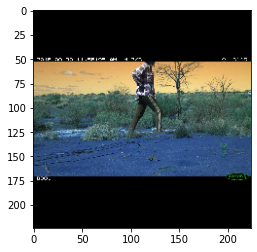

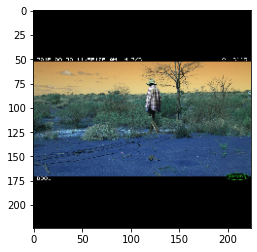

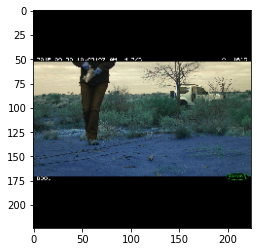

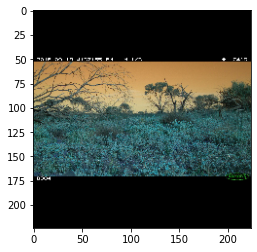

In [14]:
unlabelled_test_images = []
folders_dataset = next(os.walk('data/unlabelled_test_data/20160929_September'))[1]
folders_dataset = sorted(folders_dataset)
print('folders_dataset: {}'.format(folders_dataset))
for folder in folders_dataset:
    unlabelled_test_images = [*unlabelled_test_images, *readInImages('unlabelled_test_data/20160929_September', folder, False)]

displayImage(unlabelled_test_images[1])
displayImage(unlabelled_test_images[10])
displayImage(unlabelled_test_images[100])
displayImage(unlabelled_test_images[1000])

unlabelled_test_images = np.stack(unlabelled_test_images, axis = 0)

### Predict
* TODO: resolve encoded classes to their labels

In [15]:
y_pred = (model.predict(unlabelled_test_images) > 0.5).astype("int32")
y_classes = y_pred.argmax(axis=-1)
print('y_classes: {}'.format(y_classes))

102/102 [==============================] - 1s 14ms/step
y_classes: [3 3 3 ... 6 7 6]


## Save the model
* use the current date/time so we can keep incrementation progress of the model as we re-run it

In [16]:
if model_name == None:
    now = datetime.now()
    dt_string = now.strftime('%d-%m-%Y_%H:%M:%S')
    print("saving model as: 'ZFNet-{}.h5'.'".format(dt_string))

    model.save('saved_models/ZFNet-{}.h5'.format(dt_string))
else:
    existing_models = next(os.walk('saved_models/final'))[2]
    print('existing_models: {}'.format(existing_models))
    if model_name in existing_models:
        raise Exception('Tried to save a model that already exists. Aborting.')
    else:
        print("saving model as: '{}.h5'.'".format(model_name))
        model.save('saved_models/final/{}.h5'.format(model_name))

existing_models: ['InceptionV3-baseline-2.h5', 'InceptionV3-baseline-1.h5', 'ZFNet-baseline-3.h5', 'InceptionV3-baseline-3.h5', 'ZFNet-baseline-2.h5', 'ZFNet-baseline-1.h5']
saving model as: 'ZFNet-pre-processing-hist-eq-dark-and-canny-non-empty-1.h5'.'


## Free up the GPU's memory

In [17]:
cuda.select_device(0)
cuda.close()